In [25]:


# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('fivethirtyeight')

# Modelling and Forecasting
# ==============================================================================
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')


In [2]:


# Data download
# ==============================================================================
data = pd.read_pickle('swan_imputed_data.pkl')
data = data.rename(columns={'fecha': 'date'})
data['date'] = pd.to_datetime(data.index, format='%Y/%m/%d')
data = data.drop(columns=['missingAM', 'missingPM'])
data.index.names = ['date']
data = data.asfreq('D')
data = data.set_index('date')

# Data preparation (aggregation at daily level)
# ==============================================================================
data = data.sort_index()
data.head()

,NumberAM,NumberPM
date,,
1966-10-17,0,0
1966-10-18,0,0
1966-10-19,0,0
1966-10-20,0,0
1966-10-21,3,0


In [3]:
# Split data into train-val-test
# ==============================================================================
data = data.loc['1977-01-01':'2010-12-26']
end_train = '2004-12-31'
end_validation = '2008-12-26'
data_train = data.loc[: end_train, :].copy()
data_val   = data.loc[end_train:end_validation, :].copy()
data_test  = data.loc[end_validation:, :].copy()

print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates      : 1977-01-01 00:00:00 --- 2004-12-31 00:00:00  (n=10227)
Validation dates : 2004-12-31 00:00:00 --- 2008-12-26 00:00:00  (n=1457)
Test dates       : 2008-12-26 00:00:00 --- 2010-12-26 00:00:00  (n=731)


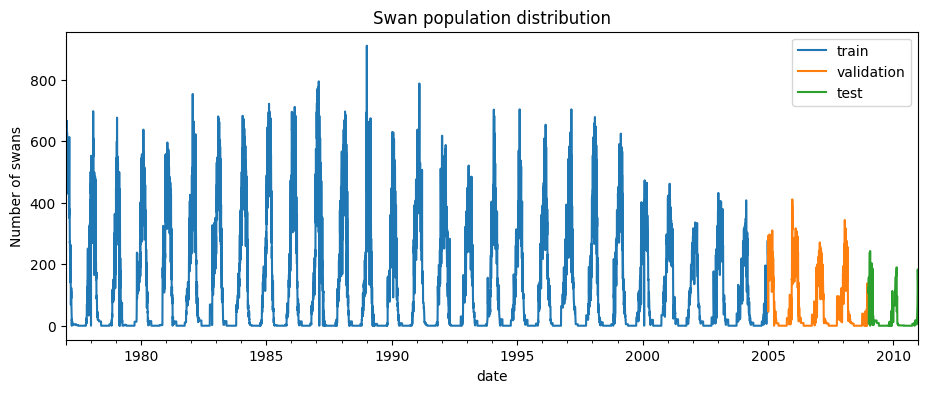

In [4]:
# Plot time serie partition
# ==============================================================================
fig, ax=plt.subplots(figsize=(11, 4))
data_train['NumberAM'].plot(label='train', ax=ax)
data_val['NumberAM'].plot(label='validation', ax=ax)
data_test['NumberAM'].plot(label='test', ax=ax)
ax.yaxis.set_major_formatter(ticker.EngFormatter())
ax.set_ylabel('Number of swans')
ax.set_title('Swan population distribution')
ax.legend();

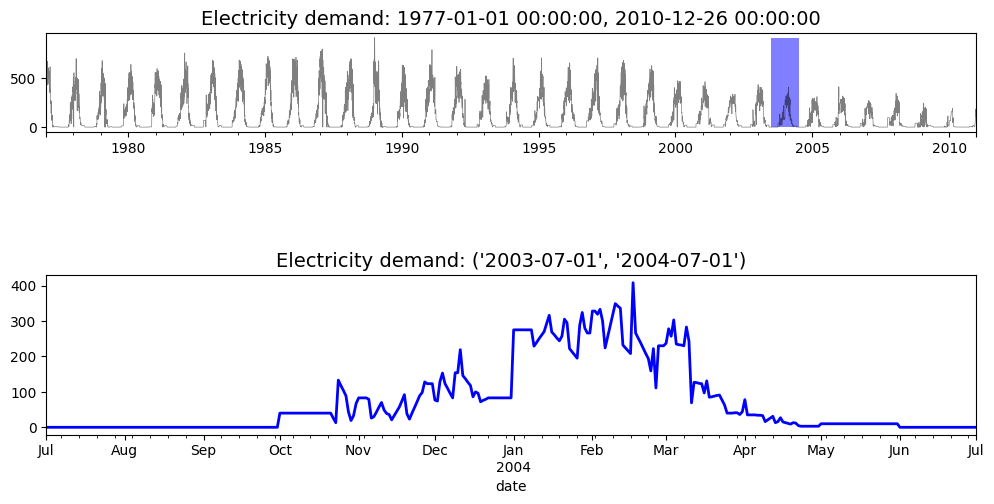

In [17]:


# Zooming time series chart
# ==============================================================================
zoom = ('2003-07-01','2004-07-01')

fig = plt.figure(figsize=(12, 6))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.6, wspace=0)

main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[5:, :])

data.NumberAM.plot(ax=main_ax, c='black', alpha=0.5, linewidth=0.5)
min_y = min(data.NumberAM)
max_y = max(data.NumberAM)
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_xlabel('')

data.loc[zoom[0]: zoom[1]].NumberAM.plot(ax=zoom_ax, color='blue', linewidth=2)

main_ax.set_title(f'Electricity demand: {data.index.min()}, {data.index.max()}', fontsize=14)
zoom_ax.set_title(f'Electricity demand: {zoom}', fontsize=14)
plt.subplots_adjust(hspace=1)



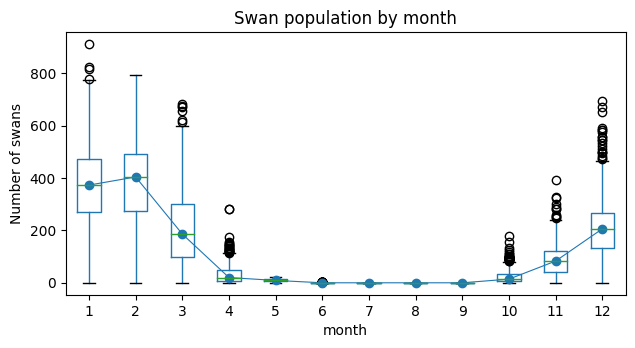

In [19]:


# Boxplot for annual seasonality
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3.5))
data['month'] = data.index.month
data.boxplot(column='NumberAM', by='month', ax=ax,)
data.groupby('month')['NumberAM'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Number of swans')
ax.set_title('Swan population by month')
fig.suptitle('');



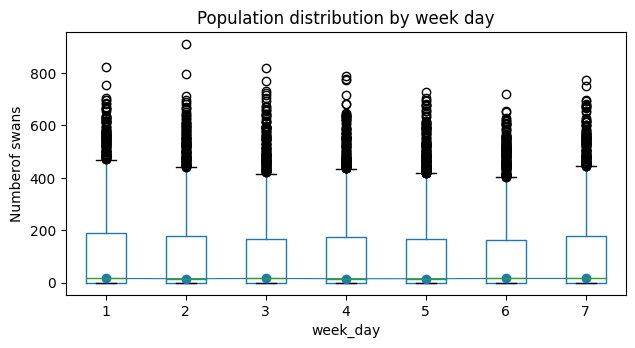

In [20]:
# Boxplot for weekly seasonality
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3.5))
data['week_day'] = data.index.day_of_week + 1
data.boxplot(column='NumberAM', by='week_day', ax=ax)
data.groupby('week_day')['NumberAM'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Numberof swans')
ax.set_title('Population distribution by week day')
fig.suptitle('');

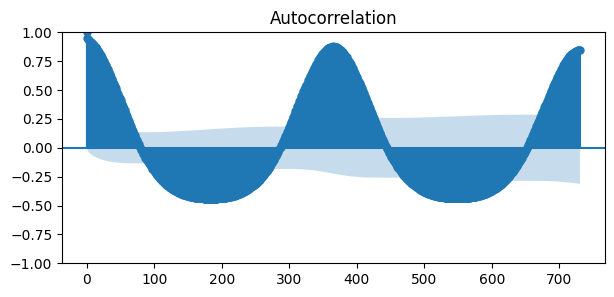

In [23]:
fig, ax = plt.subplots(figsize=(7, 3))
plot_acf(data.NumberAM, ax=ax, lags=730)
plt.show()

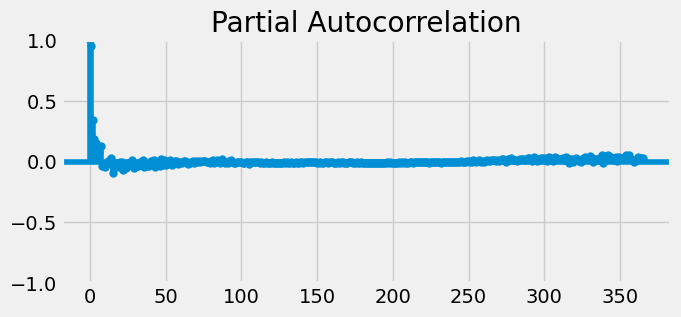

In [27]:


# Partial autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
plot_pacf(data.NumberAM, ax=ax, lags=365)
plt.show()



In [28]:


# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor     = Ridge(random_state=123),
                 lags          = 365,
                 transformer_y = StandardScaler()
             )

forecaster.fit(y=data.loc[:end_validation, 'NumberAM'])
forecaster



ForecasterAutoreg 
Regressor: Ridge(random_state=123) 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 23

In [29]:
# Backtest
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data.NumberAM,
                          initial_train_size = len(data.loc[:end_validation]),
                          fixed_train_size   = False,
                          steps              = 24,
                          metric             = 'mean_absolute_error',
                          refit              = False,
                          verbose            = True
                      )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 11683
Number of observations used for backtesting: 730
    Number of folds: 31
    Number of steps per fold: 24
    Last fold only includes 10 observations.

Data partition in fold: 0
    Training:   1977-01-01 00:00:00 -- 2008-12-26 00:00:00  (n=11683)
    Validation: 2008-12-27 00:00:00 -- 2009-01-19 00:00:00  (n=24)
Data partition in fold: 1
    Training:   1977-01-01 00:00:00 -- 2008-12-26 00:00:00  (n=11683)
    Validation: 2009-01-20 00:00:00 -- 2009-02-12 00:00:00  (n=24)
Data partition in fold: 2
    Training:   1977-01-01 00:00:00 -- 2008-12-26 00:00:00  (n=11683)
    Validation: 2009-02-13 00:00:00 -- 2009-03-08 00:00:00  (n=24)
Data partition in fold: 3
    Training:   1977-01-01 00:00:00 -- 2008-12-26 00:00:00  (n=11683)
    Validation: 2009-03-09 00:00:00 -- 2009-04-01 00:00:00  (n=24)
Data partition in fold: 4
    Training:   1977-01-01 00:00:00 -- 2008-

In [31]:
first = predictions.index.values[0:]
print(len(first))

730


In [37]:
preds = pd.DataFrame(predictions)
datetime=[]
for element in first:    
    datetime.append(pd.to_datetime(element, unit='D',origin=pd.Timestamp('2007-12-25')))
preds['date'] = datetime
preds.head()

preds = preds.set_index('date')

In [38]:
preds.head()
predictions = preds.copy()

In [39]:
predictions.tail()

,pred
date,
2008-12-29,50.216129
2008-12-30,51.551538
2008-12-31,51.892439
2009-01-01,52.144995
2009-01-02,49.555408


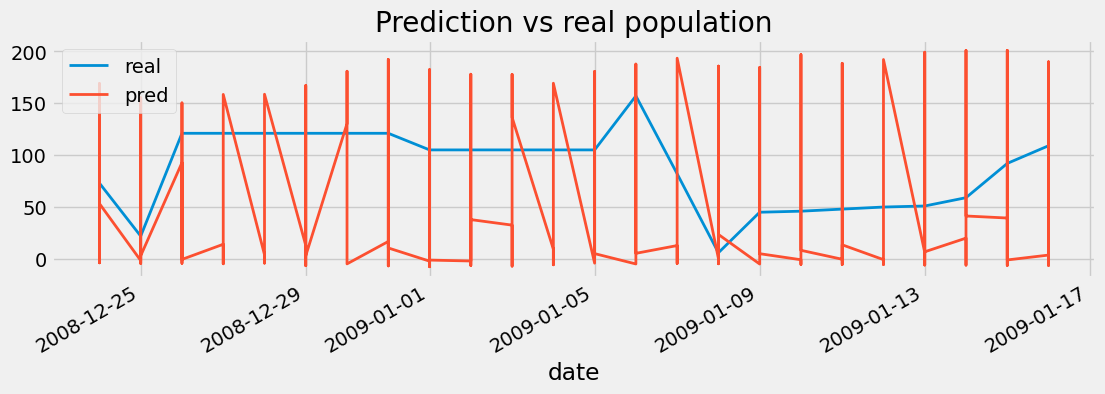

In [44]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 3.5))
data.loc[predictions.index, 'NumberAM'].plot(ax=ax, linewidth=2, label='real')
predictions.plot(linewidth=2, label='prediction', ax=ax)
ax.set_title('Prediction vs real population')
ax.legend();

In [41]:


# Backtest error
# ==============================================================================
print(f'Backtest error: {metric}')



Backtest error: 16.259413855956858
